*** epoch1, train loss 0.3545, train rmse 12.9979, val loss 0.0052, val rmse 1.725415, time use 2.768s
*** epoch2, train loss 0.0047, train rmse 1.6535, val loss 0.0048, val rmse 1.656704, time use 2.796s
*** epoch3, train loss 0.0044, train rmse 1.5891, val loss 0.0044, val rmse 1.579043, time use 2.711s
*** epoch4, train loss 0.0040, train rmse 1.5141, val loss 0.0040, val rmse 1.510573, time use 2.612s
*** epoch5, train loss 0.0035, train rmse 1.4299, val loss 0.0035, val rmse 1.407850, time use 2.761s
*** epoch6, train loss 0.0031, train rmse 1.3350, val loss 0.0032, val rmse 1.344917, time use 2.934s
*** epoch7, train loss 0.0027, train rmse 1.2410, val loss 0.0027, val rmse 1.239782, time use 2.942s
*** epoch8, train loss 0.0024, train rmse 1.1654, val loss 0.0025, val rmse 1.182062, time use 2.919s
*** epoch9, train loss 0.0021, train rmse 1.1065, val loss 0.0023, val rmse 1.132023, time use 2.915s
*** epoch10, train loss 0.0020, train rmse 1.0682, val loss 0.0022, val rmse 1.10

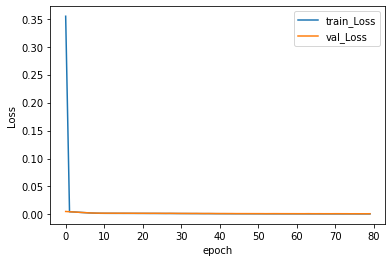

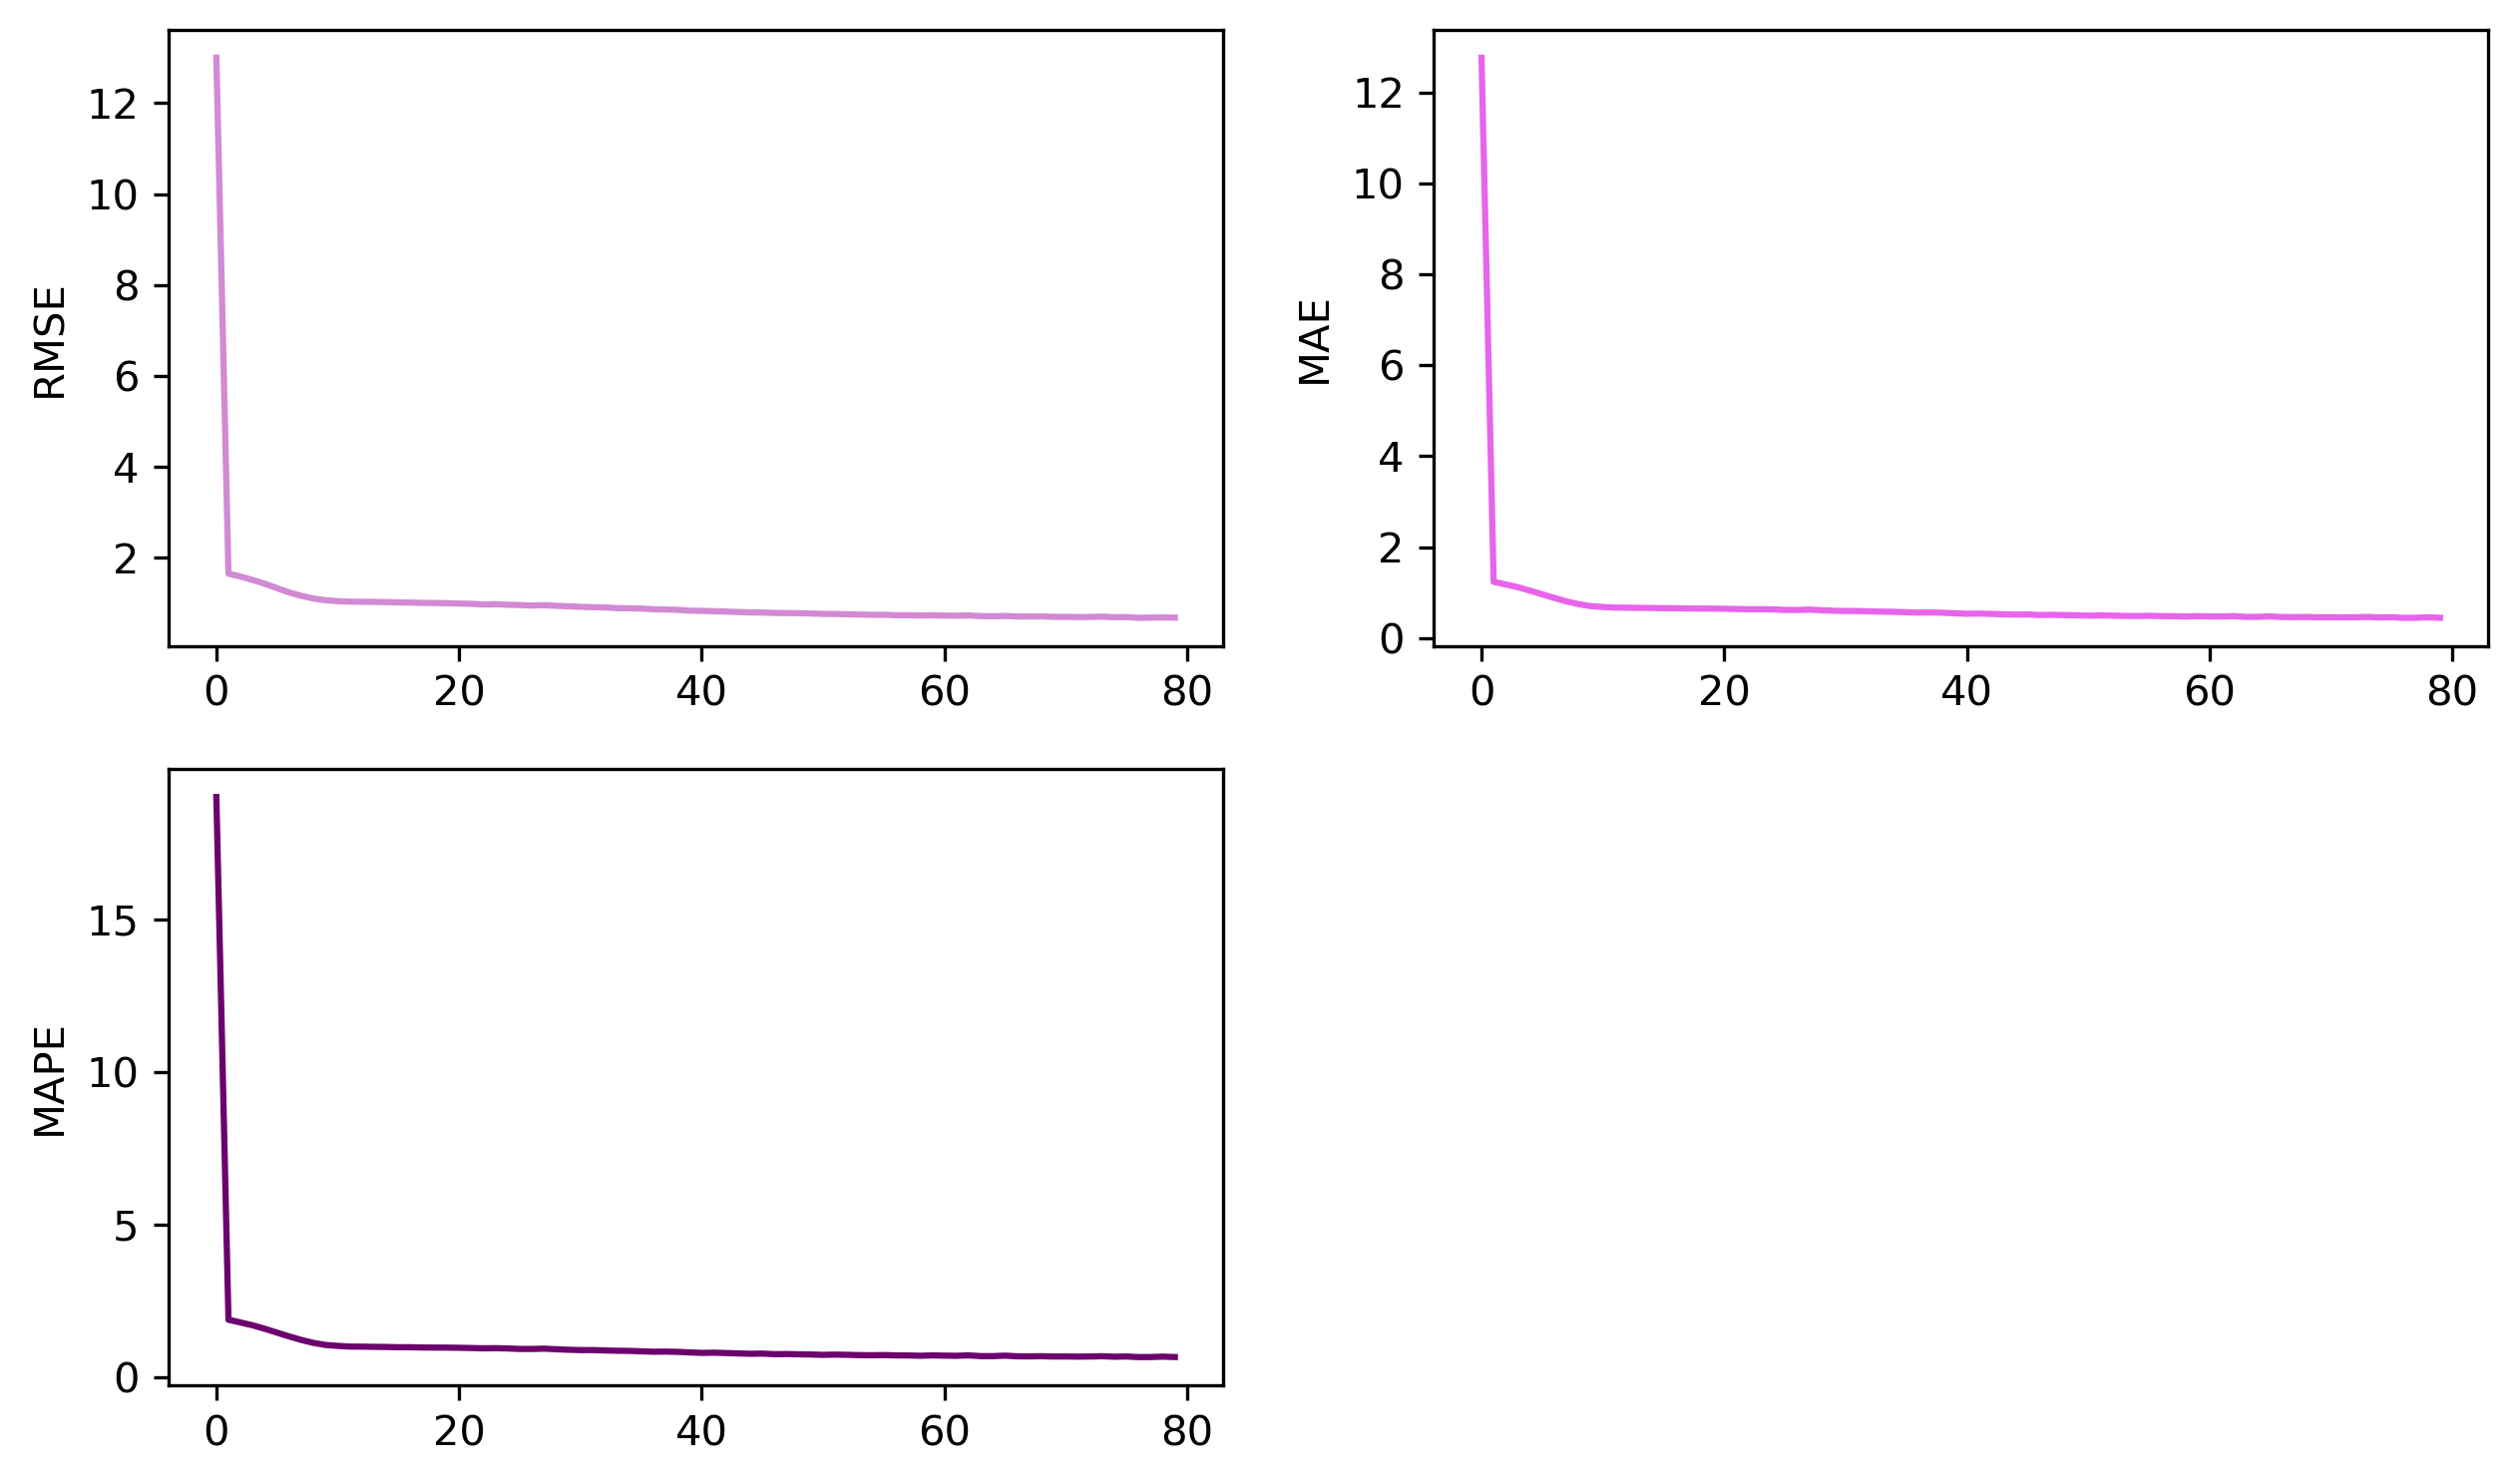

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn as nn
import torch.utils.data as data
import warnings
from torch.utils.data import DataLoader,Dataset
warnings.filterwarnings("ignore") 
import random  
from IPython import display  
from matplotlib import pyplot as plt    
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import pandas as pd  
from sklearn.utils import shuffle  
import math  
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae  
import datasets
import utils
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn


def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mse_fn(y, pred)
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]

# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]
    
class TrafficDataset:
    def __init__(self):
        self.raw_data = np.load(r'C:\Users\20693\Desktop\实验4_22121501_束天成\dataset\Traffic\Traffic.npz')['data']
        # self.raw_data = pd.DataFrame(self.raw_data)
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        window_size = 12
        len_train = int(self.data.shape[0] * 0.6)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i + window_size].squeeze())
            train_y.append(train_seqs[i + window_size].squeeze())

        len_val = int(self.data.shape[0] * 0.8)
        val_seqs = self.data[len_train:len_val]
        for i in range(val_seqs.shape[0] - window_size):
            val_x.append(train_seqs[i:i + window_size].squeeze())
            val_y.append(train_seqs[i + window_size].squeeze())

        test_seqs = self.data[len_val:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i + window_size].squeeze())
            test_y.append(test_seqs[i + window_size].squeeze())

        train_set = my_Dataset(torch.Tensor(train_x).unsqueeze(-1), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x).unsqueeze(-1), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x).unsqueeze(-1), torch.Tensor(test_y))
        return train_set, val_set, test_set


batch_size = 64    
TrafficData = TrafficDataset()
train_set,val_set,test_set = TrafficData.construct_set(0.6,0.2,12)
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
test_loader = data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0,drop_last=True)
print(train_loader)
print(val_loader)
print(test_loader)


###########前面是数据读取部分，已完成勿动###########
###########前面是数据读取部分，已完成勿动###########



# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output,hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss() 

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, TrafficData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)


visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)


# In[ ]:





# In[ ]:




